In [2]:
import os
import requests
import pandas as pd
import json
from datetime import datetime, timedelta
import time
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress
import statsmodels.api as sm

In [6]:
frame=pd.read_csv('../FullData/totaldataset.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
def strpDateTime(data):
    return data['trx_timestamp'].apply(lambda x : datetime.strptime(x[:10]+x[11:19],"%Y-%m-%d%H:%M:%S"))
def dropCols(data):
    #d_memo and maybe block_num may have some relevance later on
    return data.drop(['account_action_seq','block_num','d_memo','authorization','global_action_seq','data','name','trx_id','trx_timestamp_unix'],axis=1)
def applyLabels(data):
    list_bots=['edgarwinston','Griffinhamza','jacksonjimmy','1ffyqhg4rmbk','1ffyqhg4rmbk','powellernest','2rezoaf4bhly','nckj42dit5sb','scottphillip','oepa252sdx4p','myh2o4wayvxg']
    list_humans=['g44dinjygene','onebrother11','rvrkingfishr','iloveyoudapp','huiyong12345','pketothemoon','zhshj1212123','vipgamedice2','dldldldldldl','pkeniubixxxx']
    data['bot_label']=data['d_from'].apply(lambda x: 1 if x in list_bots else (0 if x in list_humans else None))
def dataProcess(data):
    data['trx_timestamp']=strpDateTime(data)
    data['hours']=[i.hour for i in data['trx_timestamp']]
    data['minutes']=[i.minute for i in data['trx_timestamp']]
    data['seconds']=[i.second for i in data['trx_timestamp']]
    data['day']=[i.day for i in data['trx_timestamp']]
    applyLabels(data)
    return dropCols(data)

In [8]:
def timeseries_daily_agg(data):
    '''
    Pulling together all data on an hourly basis and applying count_txns and volume_eos to it
    @params:
    data is the transaction data set
    
    
    '''
    daily_index=pd.date_range(start="3/1/2019", end="4/1/2019", freq="D")
    timeseries_dummy = pd.DataFrame(0, index=daily_index, columns=['count_txns', 'volume_eos'])
    timeseries_dummy=timeseries_dummy.astype(float)
    for index, row in data.iterrows(): 
        time=row['trx_timestamp'].replace(microsecond=0, second=0, minute=0,hour=0)
        timeseries_dummy.loc[time]['count_txns']=1+timeseries_dummy.loc[time]['count_txns']
        timeseries_dummy.loc[time]['volume_eos']=row['d_quantity']+ timeseries_dummy.loc[time]['volume_eos']
    return timeseries_dummy
    

In [9]:
def timeseries_hourly_agg(data):
    '''
    Pulling together all data on an hourly basis and applying count_txns and volume_eos to it
    @params:
    data is the transaction data set
    
    
    '''
    hour_index=pd.date_range(start="3/1/2019", end="4/1/2019", freq="H")
    timeseries_dummy = pd.DataFrame(0, index=hour_index, columns=['count_txns', 'volume_eos'])
    timeseries_dummy=timeseries_dummy.astype(float)
    for index, row in data.iterrows(): 
        time=row['trx_timestamp'].replace(microsecond=0, second=0, minute=0)
        timeseries_dummy.loc[time]['count_txns']=1+timeseries_dummy.loc[time]['count_txns']
        timeseries_dummy.loc[time]['volume_eos']=row['d_quantity']+ timeseries_dummy.loc[time]['volume_eos']
    return timeseries_dummy

In [52]:
def maxAutoCorrelation(data,user):
    '''
    Returns a tuple with maxAutoCorrelation and lag period as values
    '''
    maxAuto=0
    l=0
    data=timeseries_hourly_agg(data[data['d_from']==user])
    
    
    for i in range(1,168):
        check=data['count_txns'].autocorr(lag=i)
        if (check > maxAuto):
            maxAuto=check
            l=i
    
    return ((maxAuto,l),

In [53]:
def stdevVolumeSent(data,user):
    '''
    Returns a tuple with maxAutoCorrelation and lag period as values
    1-48 hour periods
    '''
    hold=0
    l=0
    data=data[data['Account']==user]
    return np.std(data['AmountDEX']['value'])

In [54]:
def countTotalTransactions(data,account_name):
    return data[data['d_from']==account_name].shape[0]

In [55]:
def getSubSetData(data,low,high):
    user_counts = data['d_from'].value_counts().rename('user_counts')

    zip_data_df = data.merge(user_counts.to_frame(),
                                left_on='d_from',
                                right_index=True)
    return zip_data_df[(zip_data_df['user_counts']>low) & (zip_data_df['user_counts']<high)]

In [56]:
def stdevVolumeSent(data,user):
    '''
    Returns a value of the standard deviation of volume of EOS sent
    '''
    hold=0
    l=0
    return np.std([x for x in data[data['d_from']==user]['d_quantity'].tolist()])

In [98]:
def daily_agg_features(data,user):
    data=data[data['d_from']==user]
    agg_df=timeseries_daily_agg(data)
    numActiveDays=agg_df['count_txns'].astype(bool).sum(axis=0)
    maxTxnsDay=max(agg_df['count_txns'])
    minTxnsDay=min(agg_df['count_txns'])
    
    avgTxnsPerActiveDays=sum(agg_df['count_txns'])/numActiveDays
    
    #getting the number of txns on weekdays vs. the number on weekends
    numTxnsWeekdays=sum(agg_df[agg_df.index.get_level_values(0).weekday<5]['count_txns'])
    numTxnsWeekends=sum(agg_df[agg_df.index.get_level_values(0).weekday>5]['count_txns'])
    
    numActiveDaysWeekdays=agg_df[agg_df.index.get_level_values(0).weekday<5]['count_txns'].astype(bool).sum(axis=0)
    numActiveDaysWeekends=agg_df[agg_df.index.get_level_values(0).weekday>5]['count_txns'].astype(bool).sum(axis=0)
    
    return (numActiveDays,maxTxnsDay,minTxnsDay,avgTxnsPerActiveDays,numTxnsWeekdays,numTxnsWeekends,numActiveDaysWeekdays,numActiveDaysWeekends)
    
    

In [99]:
def hourly_agg_features(data,user):
    '''
    Returns hourly features
    '''
    maxAuto=0
    l=0
    agg_df=timeseries_hourly_agg(data[data['d_from']==user])
    for i in range(1,168):
        check=agg_df['count_txns'].autocorr(lag=i)
        if (check > maxAuto):
            maxAuto=check
            #the lag period with the maxAutoCorr
            l=i

    numofTxns=sum(agg_df['count_txns'])
    
    #of active hours
    numActiveHours=agg_df['count_txns'].astype(bool).sum(axis=0)
    
    maxTxnsHour=max(agg_df['count_txns'])
    minTxnsHour=min(agg_df['count_txns'])
    
    txnsPerActiveHour=numofTxns/numActiveHours
    
    numActiveHoursWeekdays=agg_df[agg_df.index.get_level_values(0).weekday<5]['count_txns'].astype(bool).sum(axis=0)
    numActiveHoursWeekends=agg_df[agg_df.index.get_level_values(0).weekday>5]['count_txns'].astype(bool).sum(axis=0)
    
    return ((maxAuto,l),numActiveHours,maxTxnsHour,minTxnsHour,txnsPerActiveHour,numActiveHoursWeekdays,numActiveHoursWeekends)

In [101]:
def accountAgg(data):
    list_accounts=data['d_from'].unique()
    dic={}
    dic={el:[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] for el in list_accounts}
    for key in dic.keys():
        
        hourly_features=hourly_agg_features(data,key)
        
        dic[key][0]=hourly_features[0][0]
        dic[key][1]=countTotalTransactions(data,key)
        dic[key][2]=stdevVolumeSent(data,key)
        
        #daily aggregation features
        daily=daily_agg_features(data,key)
        dic[key][3]=daily[0]
        dic[key][4]=daily[1]
        dic[key][5]=daily[2]
        dic[key][6]=daily[3]
        dic[key][7]=daily[4]
        dic[key][8]=daily[5]
        dic[key][9]=daily[6]
        dic[key][10]=daily[7]
        
        #other hourly features
        dic[key][11]=hourly_features[1]
        dic[key][12]=hourly_features[2]
        dic[key][13]=hourly_features[3]
        dic[key][14]=hourly_features[4]
        dic[key][15]=hourly_features[5]
        dic[key][16]=hourly_features[6]
        
    
    return pd.DataFrame.from_dict(dic,orient='index',columns=['maxAutoCorrelation','numberofTxns','stDevEosSent','numActiveDays','maxTxnsDay','minTxnsDay','avgTxnsPerActiveDays','numTxnsWeekdays','numTxnsWeekends','numActiveDaysWeekdays','numActiveWeekends','numActiveHours','maxTxnsHour','minTxnsHour','txnsPerActiveHour','numActiveHoursWeekdays','numActiveHoursWeekends']).reset_index()
    

In [12]:
clean_frame=dataProcess(frame)

In [13]:
clean_frame

,account,d_from,d_quantity,d_quantity_unit,d_to,dapp_code,trx_timestamp,hours,minutes,seconds,day,bot_label
0,eosio.token,justiceariel,0.1000,EOS,endlessdicex,Endless Dice,2019-03-07 00:00:02,0,0,2,7,NaN
1,eosio.token,eossuperplay,0.1000,EOS,endlessdicex,Endless Dice,2019-03-07 00:00:03,0,0,3,7,NaN
2,eosio.token,nmslnmslnmsl,0.2000,EOS,endlessdicex,Endless Dice,2019-03-07 00:00:04,0,0,4,7,NaN
3,eosio.token,edgarwinston,0.1000,EOS,endlessdicex,Endless Dice,2019-03-07 00:00:06,0,0,6,7,1.0
4,eosio.token,raidenkeegan,0.1000,EOS,endlessdicex,Endless Dice,2019-03-07 00:00:09,0,0,9,7,NaN
5,eosio.token,endlessdicex,0.0980,EOS,endlessbank1,Endless Dice,2019-03-07 00:00:11,0,0,11,7,NaN
6,eosio.token,endlessdicex,0.0008,EOS,endlessdivdn,Endless Dice,2019-03-07 00:00:11,0,0,11,7,NaN
7,eosio.token,endlessdicex,0.0012,EOS,endlessoptex,Endless Dice,2019-03-07 00:00:11,0,0,11,7,NaN
8,eosio.token,endlessdicex,0.0980,EOS,endlessbank1,Endless Dice,2019-03-07 00:00:11,0,0,11,7,NaN
9,eosio.token,endlessdicex,0.0008,EOS,endlessdivdn,Endless Dice,2019-03-07 00:00:11,0,0,11,7,NaN


In [102]:
data=accountAgg(getSubSetData(clean_frame,30,200))

In [103]:
data.to_csv('../Data/clusteringDataSet1.csv')

In [104]:
data=pd.read_csv('../Data/clusteringDataSet1.csv')

In [105]:
data

,Unnamed: 0,index,maxAutoCorrelation,numberofTxns,stDevEosSent,numActiveDays,maxTxnsDay,minTxnsDay,avgTxnsPerActiveDays,numTxnsWeekdays,numTxnsWeekends,numActiveDaysWeekdays,numActiveWeekends,numActiveHours,maxTxnsHour,minTxnsHour,txnsPerActiveHour,numActiveHoursWeekdays,numActiveHoursWeekends
0,0,edgarwinston,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
1,1,raidenkeegan,0.579704,41,3.864911e-01,31,11.0,0.0,1.322581,21.0,15.0,21,5,31,11.0,0.0,1.322581,21,5
2,2,heathderrick,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
3,3,jakobantoine,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
4,4,bryantjaylon,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
5,5,karsonskylar,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
6,6,luisclarence,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
7,7,griffinhamza,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
8,8,miguelmalaki,0.914547,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
9,9,devinbeckham,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5


In [35]:
def plot_heatmap_bot_detection(data,user):
    #data is processed dataframe
    
    plot_frame=timeseries_hourly_agg(data[data['d_from']==user])
    plot_frame['Date'] = plot_frame.index.date
    plot_frame['Hour'] = plot_frame.index.hour
    
    df3 = pd.pivot_table(plot_frame, values='count_txns', index='Hour', columns='Date')
    sns.set()
    ax = sns.heatmap(df3,cmap='RdPu')
    plt.show()



In [37]:
new_list_of_bots=[]
new_list_of_huamns=[]

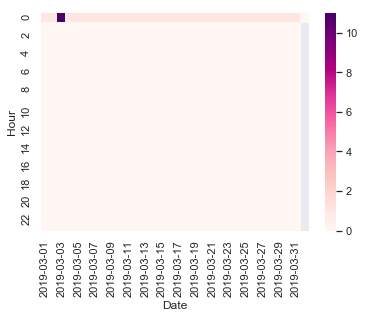

In [36]:
plot_heatmap_bot_detection(clean_frame,'raidenkeegan')

Looks like a bot, even though there is some change in eos transactions

In [40]:
new_list_of_bots.append('raidenkeegan')

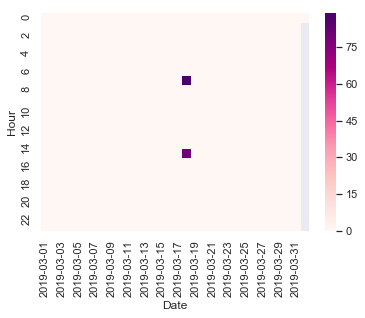

In [38]:
plot_heatmap_bot_detection(clean_frame,'ha2tqmjsgqge')

In [39]:
new_list_of_huamns.append('ha2tqmjsgqge')

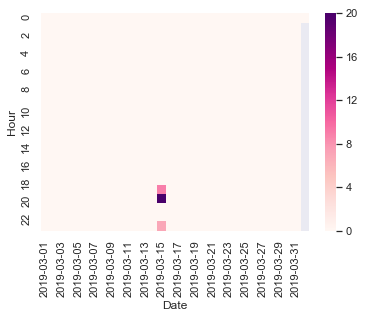

In [41]:
plot_heatmap_bot_detection(clean_frame,'bidream3idxx')

In [42]:
new_list_of_huamns.append('bidream3idxx')